# Building a Shallow Neural Network with `tensorflow`

Now that we've coded up our neural network by building a computational graph with `theano`, we'll do the same with `tensorflow`. Once we build this computational graph, we'll take advantage of the automatic differentiation that `tensorflow` offers. 

## Computational Graphs for our Shallow Neural Network

Let's again keep the visuals of the forward and backward propagation steps around as a reference: 

### Forward Propagation

<img src="https://github.com/sallamander/neural-networks-intro/blob/master/mini-books/shallow-neural-networks/imgs/custom/shallow_nonlinear_connect_forprop.png?raw=true" width=450 \>

### Backward Propagation

<img src="https://github.com/sallamander/neural-networks-intro/blob/master/mini-books/shallow-neural-networks/imgs/custom/shallow_nonlinear_connect_backprop.png?raw=true" width=600 \>

### Building a computational graph with `tensorflow`

Coding up our neural network with `tensorflow` will look pretty similar to coding it up with `theano`, but with slight syntax differences. Let's dive in ...

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from datasets.general import gen_trigonometric, gen_powx
from utils.plotting import plot_func
%matplotlib inline

In [2]:
def get_tensorflow_graph(hlayer_size=2): 
    learning_rate = 0.01
    
    ######################################################
    ##### 1. Define placeholder matrices for inputs. #####
    ######################################################
    
    xs = tf.placeholder(tf.float64, name='xs') 
    ys = tf.placeholder(tf.float64, name='ys')
    
    ########################################################################
    ##### 2. Define randomly initialized values for our weights/biases #####
    ########################################################################
    
    ##### Weights/Biases connecting Layer 1 to Layer 2 #####
    W2 = tf.Variable(np.random.random(size=(1, hlayer_size)), name='W2')
    b2 = tf.Variable(np.zeros(hlayer_size), name='b2')
    
    ##### Weights/Biases connecting Layer 2 to Layer 3 #####
    W3 = tf.Variable(np.random.random(size=(hlayer_size, 1)), name='W3')
    b3 = tf.Variable(np.zeros(1), name='b3') 
    
    ##### Put all weights/biases into 
    trainable_vars = [W2, b2, W3, b3]
    
    ##############################################################
    ##### 3. Define the equation that generates predictions. #####
    ##############################################################
    
    ##### Layer 2 calculations #####
    z2 = tf.matmul(xs, W2) + b2
    a2 = tf.sigmoid(z2)
     
    ##### Layer 3 calculations #####
    yhats = tf.matmul(a2, W3) + b3
    
    #############################################################
    ##### 4. Define the equation that generates our errors. #####
    #############################################################
    
    es = 0.5 * (ys - yhats) ** 2
    
    #########################################
    ##### 5. Define the aggregate error #####
    #########################################
    
    E = tf.reduce_mean(es) # mean of squared errors 
    
    ####################################################################
    ##### 6. Take advantage of `tensorflows` optimizer to automate #####
    #####    differentiation as well as the update step.           #####
    ####################################################################
    
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    train = optimizer.minimize(E)
    
    return trainable_vars, train, xs, ys, yhats

Our neural network with `tensorflow` is going to differ from our `theano` solution in the same way that our `tensorflow` and `theano` solutions differed for multiple linear and logistic regression. Namely, `get_tensorflow_graph` will return back the steps necessary to learn the weights/biases as multiple pieces, as opposed to one callable function.  All in all, though, steps `1-5` will still correspond to the forward pass and step `6` the backward pass. There is a slight difference in step `6` with the use of a `tensorflow Optimizer`, which we'll discuss below.

In terms of the individual pieces being returned: 

1. `trainable_vars` holds each of the trainable weights/biases in our neural network (`W2`, `W3`, `b2`, and `b3`). It is returned so that we can reference it below to initialize the values for the weights/biases (see the `tf.intialize_variables` call; we could also use `tf.initialize_all_variables`). Note the generation of the weights and biases as [Variable objects](https://www.tensorflow.org/versions/r0.9/get_started/basic_usage.html#variables) - this is what allows their values to be updated and shared across iterations. 
2. `train` holds the steps necessary to calculate the gradients and perform the updates to our weights/biases. In step `6`, we feed the quantity that we want minimized (the **mean squared error**, `E`) to a [tensorflow Optimizer](https://www.tensorflow.org/versions/r0.10/api_docs/python/train.html), which provides us with a simple interface for performing gradient descent. 

 When we call [minimize](https://www.tensorflow.org/versions/r0.10/api_docs/python/train.html#processing-gradients-before-applying-them) on this `Optimizer`, it builds the calculation of the derivatives and the performing of the updates into our computational graph. It by default takes the derivatives of all of the `tf.Variable` objects that it finds in the computational graph prior to that step. Here, this is `W2`, `W3`, `b2`, and `b3`. 
 
 When `train` is run in a session below, any steps that are necessary to perform the minimization step will be run, which in effect is every step that is part of the forward and backward propagation.
3. `xs` and `ys` are placeholders for our data, and are returned so that we can tell `tensorflow` exactly what part of our graph the real data should line up with. 
4. `yhats` refer to the predictions that we are making in each iteration, and are returned so that we can look at how our network performs when it is done training. When we train the network below, we'll keep track of the final set of `yhats` that the network generates, and use those to view how well it does. 

Now, we'll use a `Session` object to perform gradient descent and learn the weights and biases of our neural network. 

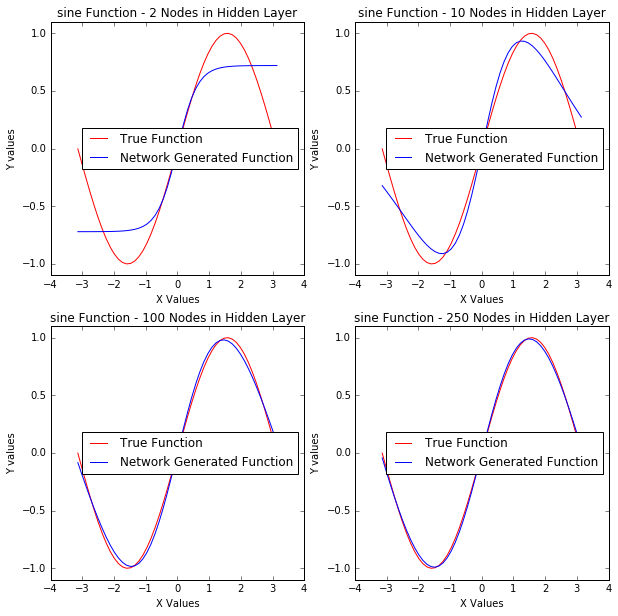

In [3]:
np.random.seed(317) # set seed for reproducibility 
# Randomly generate some fake data that follows a y = sin(x) relationship.
n_obs = 50
x, y = gen_trigonometric(n_obs=n_obs, func='sine')

# Fit four different sized networks, plotting the true function and 
# network generated function (e.g. it's predictions) for each network
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
hlayer_sizes = (2, 10, 100, 250)
for ax, hlayer_size in zip(axes.flatten(), hlayer_sizes):
    # Get the tensorflow graph with `hlayer_size` for the hidden layer.
    trainable_vars, train, xs, ys, yhats = get_tensorflow_graph(hlayer_size)
    
    # Define the initialization operation. 
    init = tf.initialize_variables(trainable_vars)
    
    with tf.Session() as sess: 
        sess.run(init) # Perform the actual initialization operation. 
        
        # Perform iterations (forward & backward prop.) over the tensorflow graph
        for step in range(50000):
            # note that `y_hats` is what is returned from the tensorflow graph,
            # while `yhats` is part of the graph
            _, y_hats = sess.run([train, yhats], feed_dict={xs : x, ys : y}) 
    plot_func(xs=x, y_true=y, y_pred=y_hats, n_nodes=hlayer_size, func='sine', ax=ax)

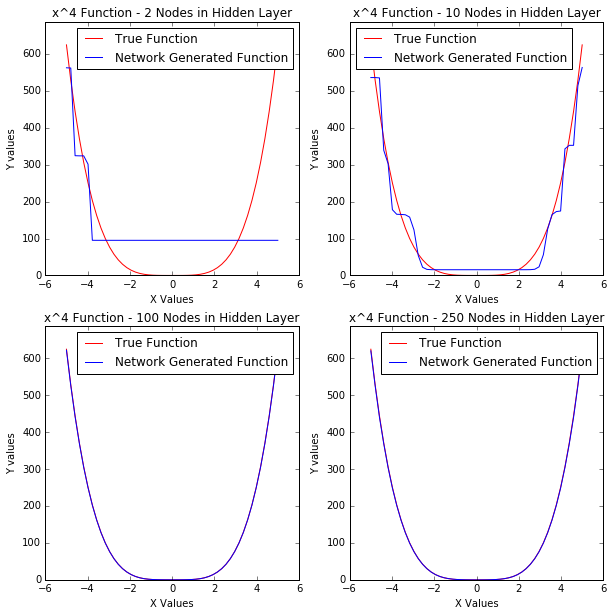

In [4]:
np.random.seed(317) # set seed for reproducibility 
# Randomly generate some fake data that follows a y = sin(x) relationship.
n_obs = 50
x, y = gen_powx(n_obs=n_obs, pow_x=4)

# Fit four different sized networks, plotting the true function and 
# network generated function (e.g. it's predictions) for each network
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
hlayer_sizes = (2, 10, 100, 250)
for ax, hlayer_size in zip(axes.flatten(), hlayer_sizes):
    # Get the tensorflow graph with `hlayer_size` for the hidden layer.
    trainable_vars, train, xs, ys, yhats = get_tensorflow_graph(hlayer_size)
    
    # Define the initialization operation. 
    init = tf.initialize_variables(trainable_vars)
    
    with tf.Session() as sess: 
        sess.run(init) # Perform the actual initialization operation. 

        # Perform iterations (forward & backward prop.) over the tensorflow graph
        for step in range(50000):
            # note that `y_hats` is what is returned from the tensorflow graph,
            # while `yhats` is part of the graph
            _, y_hats = sess.run([train, yhats], feed_dict={xs : x, ys : y}) 
    plot_func(xs=x, y_true=y, y_pred=y_hats, n_nodes=hlayer_size, func='x^4', ax=ax)

Just as with all of our other `tensorflow` implementations, we'll run gradient descent  via a `Session` object. This [Session object](https://www.tensorflow.org/versions/r0.9/api_docs/python/client.html#session-management) allows us to encapsulate all of the calculations and implementation details of our graph (or any graph) into a single environment. When running multiple graphs, each of which might have their own specialized environment, it's helpful to keep the graphs separated in some way. 

After initializing a `Session` object, our first step is to [initialize any variables](https://www.tensorflow.org/versions/r0.9/how_tos/variables/index.html#initialization) that are going to be used in the graph. Here, this is `W2`, `W3`, `b2`, and `b3`. In previous `tensorflow` implementations, we've returned each variable that we want to initialize from our `get_tensorflow_graph` function, and then explicitly passed those variables into `tf.initialize_variables`. With four variables, we probably want to avoid returning each one of them, and can instead return a list of the variables (`trainable_vars`) and pass that into `tf.initialize_variables`. 

Once we have created a `Session` object and initialized all of our variables, we can run parts of our graph or ask for values of variables by passing them into `Session.run`. Any time that we want to view the values held in the `W2` variable, for example, we run:  

```
Session.run(trainable_vars[0]) # the first element in `trainable_vars` is W2
``` 

If we run this **before** any iterations of gradient descent have been performed, we'll be given back the initial values given to each of the weights in `W2`. In order to run one iteration of the gradient descent procedure, we pass `train` into `Session.run`: 

```
Session.run(train, feed_dict={xs : x, ys : y})
```

When this piece (or any piece) of the computational graph is passed into `Session.run`, any steps necessary to compute what is asked for will be run. For `train`, this is every step of the computational graph - the forward propagation (steps `1-5`) and the backward propagation / update (step `6`). To perform these steps, `xs` and `ys` are necessary, and are passed in via the `feed_dict` argument. The keys of the `feed_dict` are the variables referring to the placeholder objects in the graph, and the values are the data that will be used for those placeholders. After running `train`, each of the weights and biases within `trainable_vars` will no longer correspond to their original values. Note that in our code above we also ask for `yhats` back, which allows us to evaluate the final predictions of our network. 

Finally, if we run `train` through `Session.run` in a loop (as we do), we see that our network built in `tensorflow` is able to learn the mathematical functions <img src="../imgs/equations/y_sinx.png" style="vertical-align: text-middle; display: inline-block; padding-top:0; margin-top:0;" width=85\>
and 
<img src="../imgs/equations/y_x4.png" style="vertical-align: text-middle; display: inline-block; padding-top:0; margin-top:0; padding-bottom:0;" width=55\>. Similar to our other implementations, we also see that more nodes in the hidden layer allows the network to have higher representational power and more accurately model these functions. 

Now, we'll move on to coding this up with `keras`. 